In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, sys
import tensorflow as tf
from PIL import Image

import helper_functions as hf
import mask_to_submission as submission_helper
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import resize_images 

In [2]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

np.random.seed(2018)

b'Hello, TensorFlow!'


In [3]:
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# Should run on GPU

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10725620540958497401
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3159988633
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5157302898058727723
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
"""
READ
Changeable parameters:
:MODEL_NAME:
:EPOCHS:
:AUGMENT_NUM:
:SALT_AND_PEPPER:
:BATCHNORMALIZAION:
:DROPOUT:
:KERNEL_SIZE: ??????????
:DILATION_RATE:
"""

MODEL_NAME = "uconvnet_dotd_unaugmented_images"
EPOCHS = 100
AUGMENT_NUM = 50
SALT_AND_PEPPER = False
BATCHNORMALIZAION = False
DROPOUT = 0.0
KERNEL_SIZE = 3
# If we want to use it, need to add a path for it, normaly it is 1 for each dimention (standard for the layers we are using
DILATION_RATE = 1

training_dir = "data/training/"
image_dir = training_dir + "images/"
gt_dir = training_dir + "groundtruth/"
aug_image_dir = training_dir + "aug_images/"
aug_gt_dir = training_dir + "aug_groundtruth/"
test_dir = "data/test_set_images/"
aug_test_dir = "data/400_test_set/"

In [7]:
files = os.listdir(image_dir)
# Load all images and groundtruths
n = len(files)
print(n)
print("Lenght of training data: " + str(n))
imgs = [hf.load_image(image_dir + files[i]) for i in range(n)]
gt_imgs = [hf.load_image(gt_dir + files[i]) for i in range(n)]

# Create augmented images if they don't exist already
aug_imgs = []
aug_gt_imgs = []
if AUGMENT_NUM != 0:
    if not os.listdir(aug_image_dir):
        print("Creating augemented pictures")
        hf.augment_images(imgs, aug_image_dir, gt_imgs, aug_gt_dir, AUGMENT_NUM)
    else:
        print("Augmented pictures exists")

    # Load in the augmented data
    files = os.listdir(aug_image_dir)
    # Load all augmented images and groundtruths
    n = len(files)
    print("Length of Augmented data: " + str(n))
    aug_imgs = [hf.load_image(aug_image_dir + files[i]) for i in range(n)] + imgs
    aug_gt_imgs_temp = [hf.load_image(aug_gt_dir + files[i]) for i in range(n)] + gt_imgs

    aug_gt_imgs = [np.expand_dims(groundtruth, len(groundtruth.shape)) for groundtruth in aug_gt_imgs_temp]
else:
    aug_imgs = imgs
    aug_gt_imgs = [np.expand_dims(groundtruth, len(groundtruth.shape)) for groundtruth in gt_imgs]
    
print("Length of Augmented data + trainin data: " + str(len(aug_gt_imgs)))

100
Lenght of training data: 100
Augmented pictures exists
Length of Augmented data: 5000
Length of Augmented data + trainin data: 5100


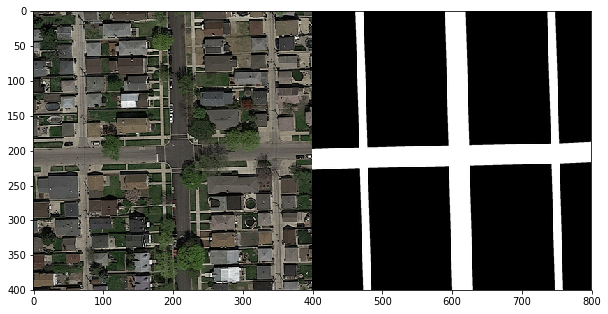

In [8]:
cimg = hf.concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

The question is if we should create salt and pepper and gaussian noice on the pictures we have or do it on duplicates effectivly doubleing the size of our dataset.

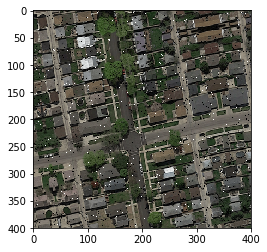

In [11]:
# Add salt and pepper to approx. 50% of the pictures, but first start with all and see what happens..
if SALT_AND_PEPPER:
    print("Adding salt and pepper to Images")
    aug_imgs = hf.add_salt_pepper_noise(aug_imgs)

print("Length of Augmented data + trainin data: " + str(len(aug_gt_imgs)))

# Image shape used for the Input layer of the network
im_height = aug_imgs[0].shape[0]
im_width = aug_imgs[0].shape[1]

plt.imshow(aug_imgs[0])

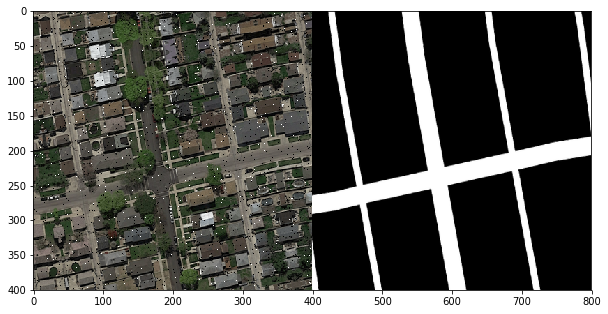

In [12]:
cimg = hf.concatenate_images(aug_imgs[0], aug_gt_imgs_temp[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [13]:
print(aug_gt_imgs[0].shape)

(400, 400, 1)


In [18]:
# Need to do this as the model expects a np.array with 4 dimentins, if we just keep the images in a list this will fail ass
# a list doesn't have a shape...
# Turning the lists into numpy array so that they will fit into the model
aug_imgs = np.array(aug_imgs)
aug_gt_imgs = np.array(aug_gt_imgs)


# Create training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(aug_imgs, aug_gt_imgs, test_size=0.20, random_state=2018)

# Model
print("Creating model with dropout: {}, batchnormalization: {} and kernelsize: {}, dilation_rate: {}".format(DROPOUT, BATCHNORMALIZAION, KERNEL_SIZE, DILATION_RATE))
input_img = Input((im_height, im_width, 3), name='img')
model = big_u_convnet.create_model(input_img, dropout=DROPOUT, batchnorm=BATCHNORMALIZAION, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE)

# Compile model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 400, 400, 16) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [119]:
weights_path = "models/model_weights/"
model_weight_name = MODEL_NAME + ".h5"
history_name = model_weight_name[:-3] + "_history"

callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor='val_loss', mode='auto'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path + model_weight_name, monitor='val_loss', mode='auto', verbose=1,
                    save_best_only=True, save_weights_only=True)
]

In [ ]:
# Fit model IF weights don't exist, else load the weights into the model
if not any(fname == model_weight_name for fname in os.listdir(weights_path)):
    print("Fitting the model over " + str(EPOCHS) + " epochs")
    results = model.fit(X_train, y_train, batch_size=4, epochs=EPOCHS, callbacks=callbacks,
                        validation_data=(X_valid, y_valid), shuffle=True)

    # Should save the history of the model too, need to add the", History callback then!
    with open(weights_path + history_name, 'wb') as file_pi:
        pickle.dump(results.history, file_pi)

else:
    print("Model weights already exists, loading them in")
    model.load_weights(weights_path + model_weight_name)

    # Evaluate on validation set (this must be equals to the best log_loss)
    model.evaluate(X_valid, y_valid, verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/100
 68/800 [=>............................] - ETA: 2:21 - loss: 2.0203 - acc: 0.7528

In [ ]:
# Variable to hold our history
history = {}

# Load in the history
history = pickle.load(open(weights_path + history_name, "rb"))

# Need to plot the history here!! Read it in if saved
hf.plot_history(history)

50
{(608, 608, 3)}
test images exists
50
(400, 400, 3)


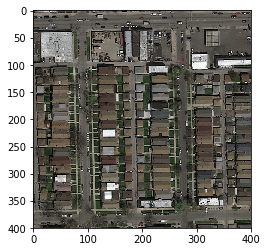

In [102]:
# Load the test data, reshape it if the shape is not the same as the training data
test_files = os.listdir(test_dir)
n = len(test_files)
print("Number of test Images: " + str(n))
image_size = (400, 400)

test_foler_name = "test_"
# Be careful to read the test data in the right order!
test_imgs = [hf.load_image(test_dir + test_foler_name + str(i+1) + "/" + os.listdir(test_dir + test_foler_name + str(i+1))[0]) for i in range(n)]

if not os.listdir(aug_test_dir):
    print("Creating 400x400 test images")
    hf.create_test_images(test_dir, aug_test_dir, test_files, n)
else:
    print("Test images exists")

# Load the 400x400 test Images
test_400_files = os.listdir(aug_test_dir)
n_400 = len(test_400_files)
print("Number of Test Images: " + str(n_400))
aug_test_imgs = [hf.load_image(aug_test_dir + "test_" + str(i+1) + ".png") for i in range(n_400)]

print("Shape of 'augmented' test data" + str(aug_test_imgs[0].shape))

In [103]:
# Prepare the test data, need to put it in a nparray to get 4 dimensions and scale them down to the same size as the
# training data

X_test = np.array(aug_test_imgs)
print(X_test.shape)

(50, 400, 400, 3)


In [105]:
# Predict on train, val and test
predictions = model.predict(X_test, batch_size=4)

In [106]:
print(predictions.shape)

(50, 400, 400, 1)


In [107]:
prediction_path = "data/predictions/"
result_path = prediction_path + "result_"

original_image_size = (608, 608)

for i in range(len(predictions)):
    im = Image.fromarray(np.uint8(np.multiply(np.squeeze(predictions[i]), 255.0)))
    im = im.resize(original_image_size, Image.ANTIALIAS)
    im.save(result_path + str(i+1) + ".png", "PNG")

50
(608, 608)
(608, 608)


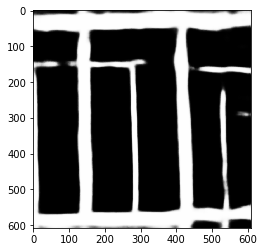

In [109]:
prediction_files = os.listdir(prediction_path)
# Load all images and groundtruths
n = len(prediction_files)
print(n)
predictions = [hf.load_image(result_path + str(i+1) + ".png") for i in range(n)]

print(predictions[0].shape)
print(np.squeeze(predictions[0]).shape)

What could be done is training a cnn on 16x16, assuming this is the mask that is used when submitting?, parts of the images, labeled 0 or 1 (ground or road) and then prediction with 16x16 Images. This may not get the context it needs to say what part of the Image is a road or not.

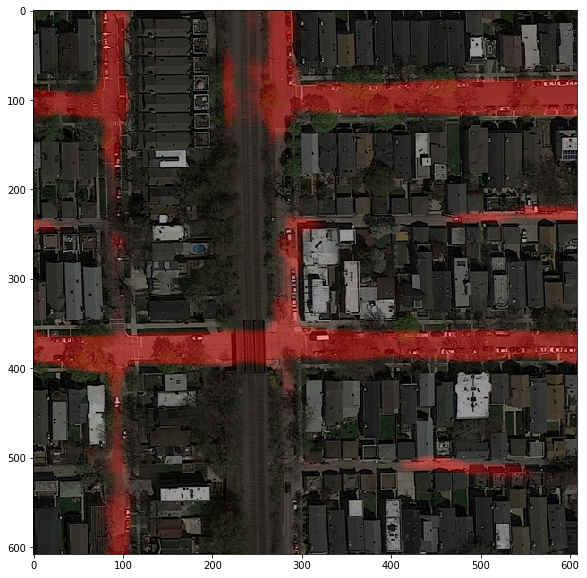

In [122]:
# Show a prediction
image_index = 32
over = hf.make_img_overlay(test_imgs[image_index], predictions[image_index])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(over)

Create a submission

In [118]:
# Create submission
submission_name = MODEL_NAME + ".csv"
path_to_submission = "submissions/" + submission_name
prediction_path = "data/predictions/"
prediction_name = "result_"

path_to_predictions = []

number_of_predictions = os.listdir(prediction_path)

for i in range(len(number_of_predictions)):
    path_to_predictions.append(prediction_path + prediction_name + str(i+1) + ".png")

print("Number of predictions " + str(len(path_to_predictions)))

submission_helper.masks_to_submission(path_to_submission, *path_to_predictions)

50
